In [ ]:
from adsorbdiff import AdsorbDiffCalculator
import ase.io
from ase.optimize import BFGS
import sys
from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

from adsorbdiff.placement import (
    Adsorbate,
    AdsorbateSlabConfig,
    Bulk,
    Slab,
    DetectTrajAnomaly,
)
import os
from glob import glob
import pandas as pd
from pathlib import Path
from ase.visualize.plot import plot_atoms
import numpy as np

Set up paths for db, checkpoints


In [ ]:
curr_path = os.getcwd()
main_path = "/".join(curr_path.split("/")[:-2])
ads_db_path = main_path + "/adsorbdiff/placement/pkls/adsorbates.pkl"
bulk_db_path = main_path + "/adsorbdiff/placement/pkls/bulks.pkl"

Download the checkpoints.

We download the PaiNN and GemNet-OC for diffusion and optimization respectively due to their good inference cost and accuracy tradeoffs. Although, other checkpoints are available if required.

In [ ]:
os.makedirs("ckpts", exist_ok=True)
!wget -q https://zenodo.org/records/11152248/files/PT_zeroshot_painn.pt ckpt/painn_diff.pt
!wget -q https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt ckpt/gnoc_relax.pt
diff_ckpt_path = "ckpt/painn_diff.pt"
relax_ckpt_path = "ckpt/gnoc_relax.pt"

A sample slab and adsorbate from the OC20-Dense data

<AxesSubplot: >

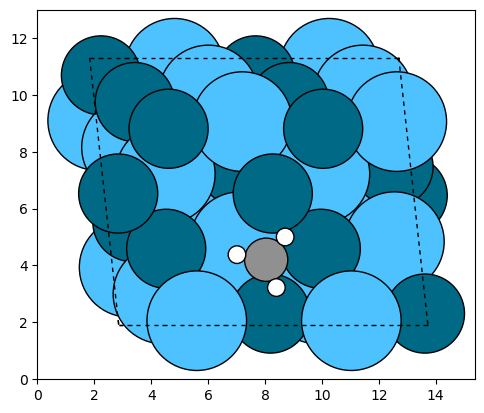

In [ ]:
random_adslab = ase.io.read("/home/jovyan/shared-scratch/adeesh/data/oc20_dense/trajs/12_1990_4/12_1990_4_rand0.traj", "0")
plot_atoms(random_adslab)

We need to set the tags to atoms which helps in defining if its a slab atom or adsorbate atom. There's a pkl file released with OC20-Dense data that has mappings from sids to tags. 

For the purpose of this example, we can just assume that atoms that have C and H are adsorbates. Note that this isn't true for all systems.

In [ ]:
tag_path = "/home/jovyan/shared-scratch/adeesh/data/oc20_dense/oc20dense_tags.pkl"

with open(os.path.join(tag_path), "rb") as h:
    tags_map = pickle.load(h)
tags = tags_map["12_1990_4"]
random_adslab.set_tags(tags_map["12_1990_4"])

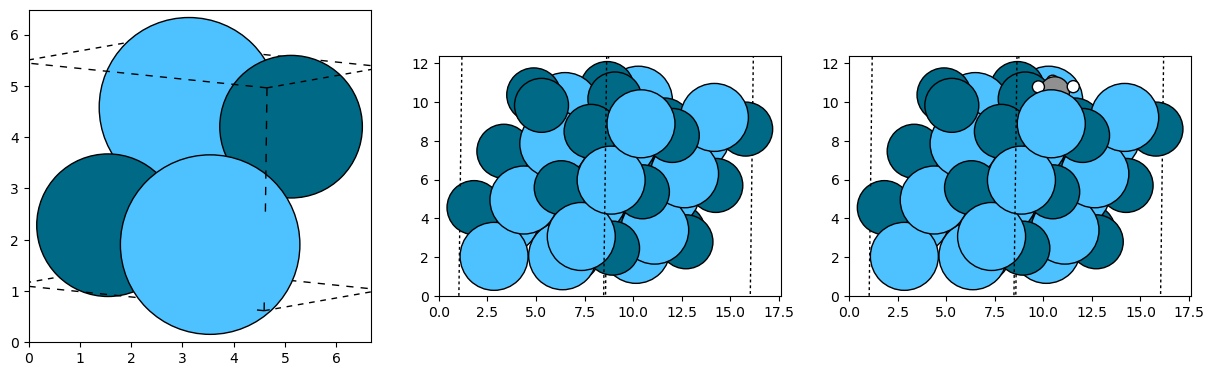

In [ ]:
sid = "12_1990_4"
ads_mask = tags == 2

adsorbate = Adsorbate(
    adsorbate_id_from_db=int(sid.split("_")[0]),
    adsorbate_db_path=ads_db_path,
)
bulk = Bulk(
    bulk_id_from_db=int(sid.split("_")[1]),
    bulk_db_path=bulk_db_path,
)

slab = Slab(bulk=bulk, slab_atoms=random_adslab[~ads_mask])

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
plot_atoms(bulk.atoms, ax=axarr[0], rotation="-75x, 45y, 10z", show_unit_cell=1)
plot_atoms(slab.atoms, ax=axarr[1], rotation="-75x, 45y, 10z", show_unit_cell=1)
plot_atoms(random_adslab, ax=axarr[2], rotation="-75x, 45y, 10z", show_unit_cell=1)
fig.show()

In [ ]:
calc_diff = AdsorbDiffCalculator(checkpoint_path=diff_ckpt_path, cpu=False)  
calc_opt = AdsorbDiffCalculator(checkpoint_path=relax_ckpt_path, cpu=False)

# Runs diffusion on the random adsorbate slab configuration
diffused_adslab = calc_diff.run_diffusion(random_adslab, trajectory="diff")

# Get the diffused adsorption site and make sure the adsorbate is placed normal to the surface at a certain insterstitial gap
diffused_adsorption_site = diffused_adslab.get_positions()[diffused_adslab.get_tags() == 2]
diffused_adslab = AdsorbateSlabConfig(slab, adsorbate, sites=diffused_adsorption_site, interstitial_gap=0.1).atoms_list[0]

# Optimize the diffused adsorbate slab configuration
diffused_adslab.calc = calc_opt
opt = BFGS(diffused_adslab, trajectory=f"opt.traj", logfile=f"log.log")
opt.run(fmax=0.05, steps=100)

 29%|██▉       | 29/100 [00:01<00:04, 14.99it/s]


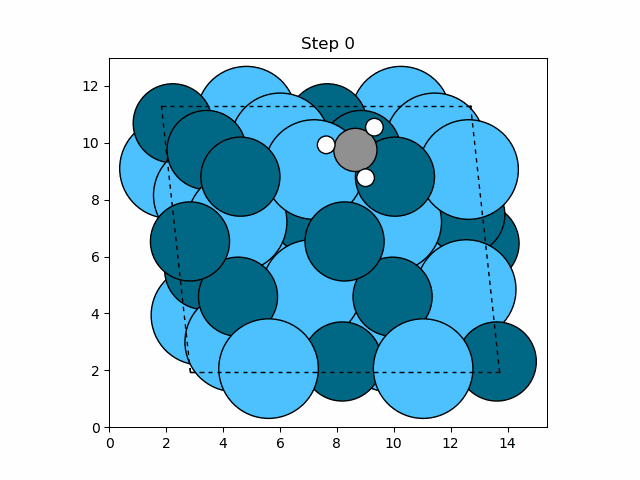

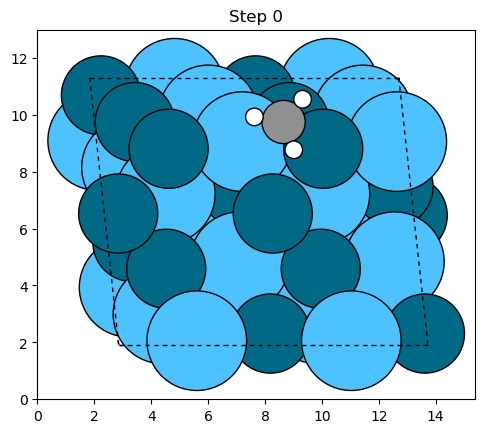

In [ ]:
diff_traj = ase.io.read("diff/0.traj", ":")

def gif_helper(frame):
    ax.clear()
    atoms = diff_traj[frame]
    plot_atoms(atoms)
    ax.set_title(f"Step {frame}")

fig, ax = plt.subplots()
anim = FuncAnimation(fig, gif_helper, frames=len(diff_traj))
anim.save("diff/diff.gif", writer="pillow", fps=1)

from IPython.display import Image
Image(filename="diff/diff.gif")

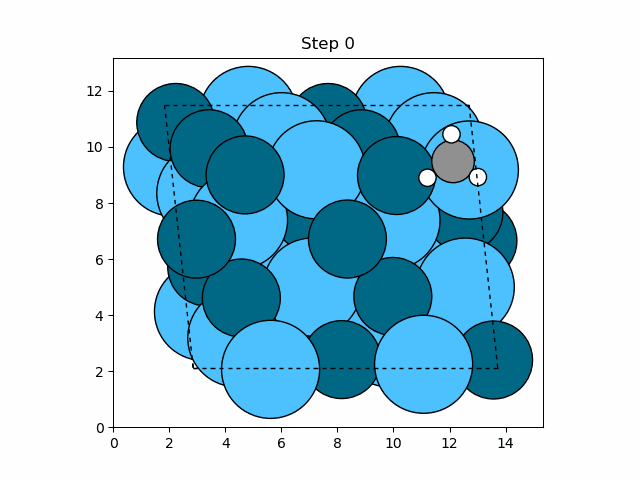

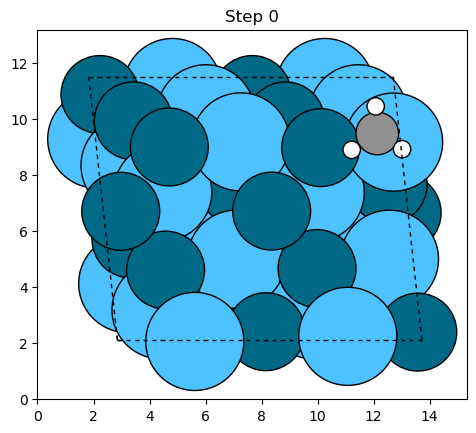

In [ ]:

# diff_traj = ase.io.read("/home/jovyan/shared-scratch/adeesh/denoising/valid_rerun/debug_painn_prev2/0/12_1990_4.traj", ":")

# def gif_helper(frame):
#     ax.clear()
#     atoms = diff_traj[frame]
#     plot_atoms(atoms)
#     ax.set_title(f"Step {frame}")

# fig, ax = plt.subplots()
# anim = FuncAnimation(fig, gif_helper, frames=len(diff_traj))
# anim.save("diff/diff.gif", writer="pillow", fps=1)

from IPython.display import Image
Image(filename="diff/diff.gif")